# Chapter 8: Building Machine Learning experiments

## Finding the best model with AutoML

The process to use AutoML to find the best model for your machine learning task consists on four steps: loading your data, configuring your Azure Machine Learning experiment, running the experiment, and exploring the results. You will perform these tasks using your Apache Spark pool and PySpark. 




The first code cell imports the libraries needed for this notebook:

In [2]:
import azureml.core

from azureml.core import Experiment, Workspace, Dataset, Datastore
from azureml.train.automl import AutoMLConfig
from notebookutils import mssparkutils
from azureml.data.dataset_factory import TabularDatasetFactory

StatementMeta(sparkdronetl24, 1, 1, Finished, Available)

Next, we define variables with the name of the linked service object that we created in the Configuring the Azure Machine Learning integration section, the name of the experiment that we created in the Finding the best model with AutoML section, and then we create a new experiment using the connection to the linked service. 

In [3]:
linkedService_name = "AzureML_telemetryexperiments"
experiment_name = "Predict_Core_Temp"

ws = mssparkutils.azureML.getWorkspace(linkedService_name)
experiment = Experiment(ws, experiment_name)

StatementMeta(sparkdronetl24, 1, 2, Finished, Available)

In the next code cell, you will see that the notebook that was automatically generated by the Train a new model wizard produces a SQL query that selects everything from the fleet_data table on the Lake Database. We want to change this to read from the table on the Data Explorer pool. Additionally, we will perform a few actions with our data once we load it into the Spark DataFrame:
- Downsample the data: our original table has over 337,500 rows. To test this notebook and make sure everything works, it’s a good idea to work with a small subset of your data to avoid the increased costs of data retrieval, and the compute costs. This code reduces the Spark DataFrame to 1% of its size. 
- Select a few columns: not all columns in your table may be useful to train a model. For example, the DeviceData column, which is a JSON column that contains the device’s ID and name, is not relevant to determining the device’s core temperature. Therefore, we’re selecting here only columns that we think may help train our regression model. We will also produce three new columns that store the hour, day of month, and day of week of the telemetry event. Having this type of data separate on new columns can sometimes help find insights related to a certain fixed time or day an event happens. 
- Split the data in training and validation sets: when you train models, you want to separate a portion of your data to train the model and use another portion of your data to validate the model accuracy (by checking predicted data against real values). In this example, we will set 80% of the available data to the training set, and 20% to the validation set. 
- Create a tabular dataset from the Spark DataFrame: this is already in the notebook that was generated by the wizard, but we want to make sure we change this function to use our training set stored in the training_set variable, and not the original, full Spark DataFrame. 

The new code for this cell is the following: 


In [4]:
# Changing the query to the Data Explorer pool table
# Make sure you change this code to use YOUR Data Explorer pool, 
# database, and table. 
df  = spark.read \
    .format("com.microsoft.kusto.spark.synapse.datasource") \
    .option("spark.synapse.linkedService", "kustoPool") \
    .option("kustoCluster", "https://droneanalyticsadx.drone-analytics.kusto.azuresynapse.net") \
    .option("kustoDatabase", "drone-telemetry") \
    .option("kustoQuery", "['fleet data']") \
    .load()

# Downsampling data
df = df.sample(True, 0.01, seed=1234)

from pyspark.sql.functions import *

# Select specific columns
df = df.select(
      'DeviceState', 
      'Engine1Status','Engine2Status','Engine3Status','Engine4Status',
      'Engine1RPM','Engine2RPM','Engine3RPM','Engine4RPM',
      'Engine1Temp','Engine2Temp','Engine3Temp','Engine4Temp',
      'CoreTemp','BatteryTemp','CoreStatus','MemoryAvailable','BatteryLevel',
      'Altitude','Speed','DistanceFromBase','RFSignal','PayloadWeight',
      date_format('LocalDateTime', 'hh').alias('HourOfDay'),
      dayofmonth('LocalDateTime').alias('DayOfMonth'),
      dayofweek('LocalDateTime').alias('DayOfWeek')
      )

# Create the training and validation dataframes
training_data, validation_data = df.randomSplit([0.8,0.2], seed=1234)

# Create a dataset from the training dataframe, 
# using the default workspace data store
datastore = Datastore.get_default(ws)
dataset = TabularDatasetFactory.register_spark_dataframe(training_data, 
      datastore, name = experiment_name + "-dataset")

StatementMeta(sparkdronetl24, 1, 3, Finished, Available)

Method register_spark_dataframe: This is an experimental method, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Validating arguments.
Arguments validated.
Writing spark dataframe to managed-dataset/b32f713c-66dd-4a8e-809b-5cf94515a8d8
Creating new dataset
Registering new dataset
Successfully created and registered a new dataset.


Next, we will add a code cell to see the structure of our new Spark DataFrame and make sure everything looks good. As we can see, the new columns we created to store the hour, day of month, and day of week values are present in the Spark DataFrame. 

In [5]:
display(df, summary=True)

StatementMeta(sparkdronetl24, 1, 4, Finished, Available)

SynapseWidget(Synapse.DataFrame, 76ceec3d-0dd6-4391-a858-2cd0c3e7366f)

The next step is to configure the parameters of the AutoML task. We will make a slight change to the code that was generated by the wizard: create a new Python dictionary with a series of parameters that we will then use when we create the actual AutoML configuration object. Our new settings limit the experiment’s timeout to 15 minutes, and defines other useful parameters. Here’s the code:

In [6]:
import logging

automl_settings = {
    "iteration_timeout_minutes": 10,
    "experiment_timeout_minutes": 15,
    "enable_early_stopping": True,
    "featurization": 'auto',
    "verbosity": logging.INFO,
    "n_cross_validations": 2}

automl_config = AutoMLConfig(spark_context = sc,
                             task = 'regression',
                             training_data = dataset,
                             label_column_name = 'CoreTemp',
                             primary_metric = 'r2_score',
                             max_concurrent_iterations = 2,
                             enable_onnx_compatible_models = False, **automl_settings)

StatementMeta(sparkdronetl24, 1, 5, Finished, Available)

We’re now finally ready to submit our AutoML experiment to Azure Machine Learning. Here, you can reuse the code generated by the wizard without any changes. This command generates a table as output, providing details about the experiment. The Details Page column offers a link to this experiment on Azure Machine Learning Studio, where you can see the status of the experiment as it runs. 

The code to submit the experiment is:

In [7]:
run = experiment.submit(automl_config, show_output=True)

StatementMeta(sparkdronetl24, 1, 6, Finished, Available)

Submitting spark run.
No run_configuration provided, running on local with default configuration


Experiment,Id,Type,Status,Details Page,Docs Page
Predict_Core_Temp,AutoML_4cfa1ed6-47fc-4154-8979-f326d720424b,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation


Running an experiment on spark cluster: Predict_Core_Temp.


Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Missing feature values imputation
STATUS:       PASSED
DESCRIPTION:  No feature missing values were detected in the training data.
              Learn more about missing value imputation: https://aka.ms/AutomatedMLFeaturization

****************************************************************************************************

TYPE:         High cardinality feature detection
STATUS:       PASSED
DESCRIPTION:  Your inputs were analyzed, and no high cardinality features were detected.
              Learn more about high cardinality feature handling: https://aka.ms/AutomatedMLFeaturization

****************************************************************************************************

**********************************************

The AutoML experiment will build a series of models with different algorithms parameters with your data. Next, we will retrieve the run that provided the best result according to the metric we specified (R2) and the model that produced this run. Once we retrieve this model, we will register it in the Azure Machine Learning model registry for future use. This code block is the same as it was created automatically for you: 

In [8]:
run.wait_for_completion()

import mlflow

# Get best model from automl run
best_run, fitted_model = run.get_output()

artifact_path = experiment_name + "_artifact"

mlflow.set_tracking_uri(ws.get_mlflow_tracking_uri())
mlflow.set_experiment(experiment_name)

with mlflow.start_run() as run:
    # Save the model to the outputs directory for capture
    mlflow.sklearn.log_model(fitted_model, artifact_path)

    # Register the model to AML model registry
    mlflow.register_model("runs:/" + run.info.run_id + "/" + artifact_path, "drone-analytics-fleet_data-20221026113234-Best")

StatementMeta(sparkdronetl24, 1, 7, Finished, Available)

Received unrecognized parameter dataset_id
Received unrecognized parameter dataset_id
Received unrecognized parameter dataset_id


Registered model 'drone-analytics-fleet_data-20221026113234-Best' already exists. Creating a new version of this model...
2023/01/06 18:51:49 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: drone-analytics-fleet_data-20221026113234-Best, version 8
Created version '8' of model 'drone-analytics-fleet_data-20221026113234-Best'.


But how good is this model, really? Let’s perform a few tasks to see its accuracy. The easiest way to do this is to use real data and see if the model that we got can predict values close to the real ones. We can do this with the following code block: 

In [9]:
import pandas as pd

# Create a Pandas DataFrame from the validation set
validation_data_pd = validation_data.toPandas()

# Create a new Pandas DataFrame with the REAL CoreTemp data
df_compare = validation_data_pd.pop('CoreTemp').to_frame()

# Predict the CoreTemp column using the fitted model
y_predict = fitted_model.predict(validation_data_pd)

# Add the predicted values to the new Pandas DataFrame
# for comparison 
df_compare['Predicted'] = y_predict
display(df_compare)

StatementMeta(sparkdronetl24, 1, 8, Finished, Available)

SynapseWidget(Synapse.DataFrame, 5cb79614-8332-47f7-b202-b6d14a24a03c)

Note that, in most cases, the predicted value is pretty close to the real value from our validation set. Those are really good results! 

To finalize the validation process, let’s compute the R2 score of our model, since that is the metric that we chose to evaluate it. The Y axis will show all the values that were predicted by our model, and the X axis will show all the actual values in the dataset. An optimal model should see the data points meet at the same Y and X coordinates, or as close as possible. You can use this code in a new code cell to perform this task: 

StatementMeta(sparkdronetl24, 1, 12, Finished, Available)

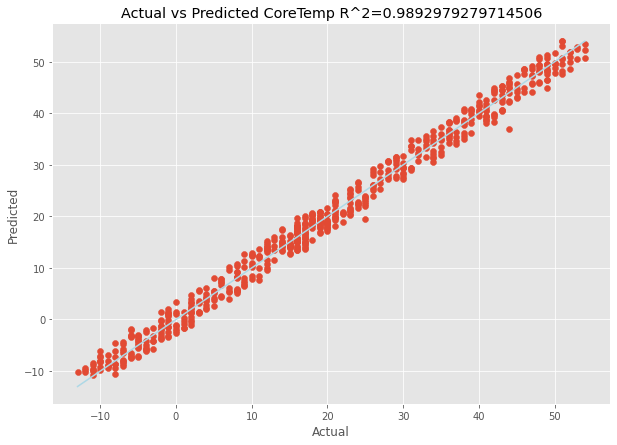

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Compute the R2 score by using the predicted and actual CoreTemp
y_test_actual = df_compare['CoreTemp']
r2 = r2_score(y_test_actual, y_predict)

# Plot the actual versus predicted CoreTemp values
plt.style.use('ggplot')
plt.figure(figsize=(10, 7))
plt.scatter(y_test_actual,y_predict)
plt.plot([np.min(y_test_actual), np.max(y_test_actual)], [np.min(y_test_actual), np.max(y_test_actual)], color='lightblue')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted CoreTemp R^2={}".format(r2))
plt.show()

As you can see, our model was very efficient at predicting values for our dataset, with an R2 score of 0.98.

An R2 score of 1 represents a perfect model that is able to predict all occurrences perfectly, while a model that has an R2 score of 0 represents a model that is not effective. For a regression model, we want to pursue an R2 score that’s as close to 1 as possible.

In [ ]:
description = 'My automated ML model'
model_path='outputs/model.pkl'
model = best_run.register_model(model_name = 'DeviceTelemetry', model_path = model_path, description = description)
print(model.name, model.version)

StatementMeta(, , , Cancelled, )